##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bonus Day - So long and farewell!

Congrats on finishing the 5-day Generative AI Intensive course from Kaggle and Google!

This notebook is a "bonus episode" that highlights a few more things you can do with the Gemini API that weren't covered during the course. This material doesn't pair with the whitepapers or podcast, but covers some extra features that you might find useful when building Gemini API powered apps.

## Get set up

Install the SDK and other tools for this notebook, then import the package and set up a retry policy so you don't have to manually retry when you hit a quota limit.

In [12]:
%pip install -q google-generativeai pydub

Note: you may need to restart the kernel to use updated packages.


You do not have to restart the kernel.

In [2]:
import google.generativeai as genai
from google.api_core import retry

retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)} 

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)

## Multi-modal prompting

As you may have noticed in AI Studio, the Gemini models support more than just text as input. You can provide pictures, videos, audio and more.


### Images

Start by downloading an image.

2024-11-15 04:18:56 URL:https://storage.googleapis.com/generativeai-downloads/images/cake.jpg [253809/253809] -> "cake.jpg" [1]


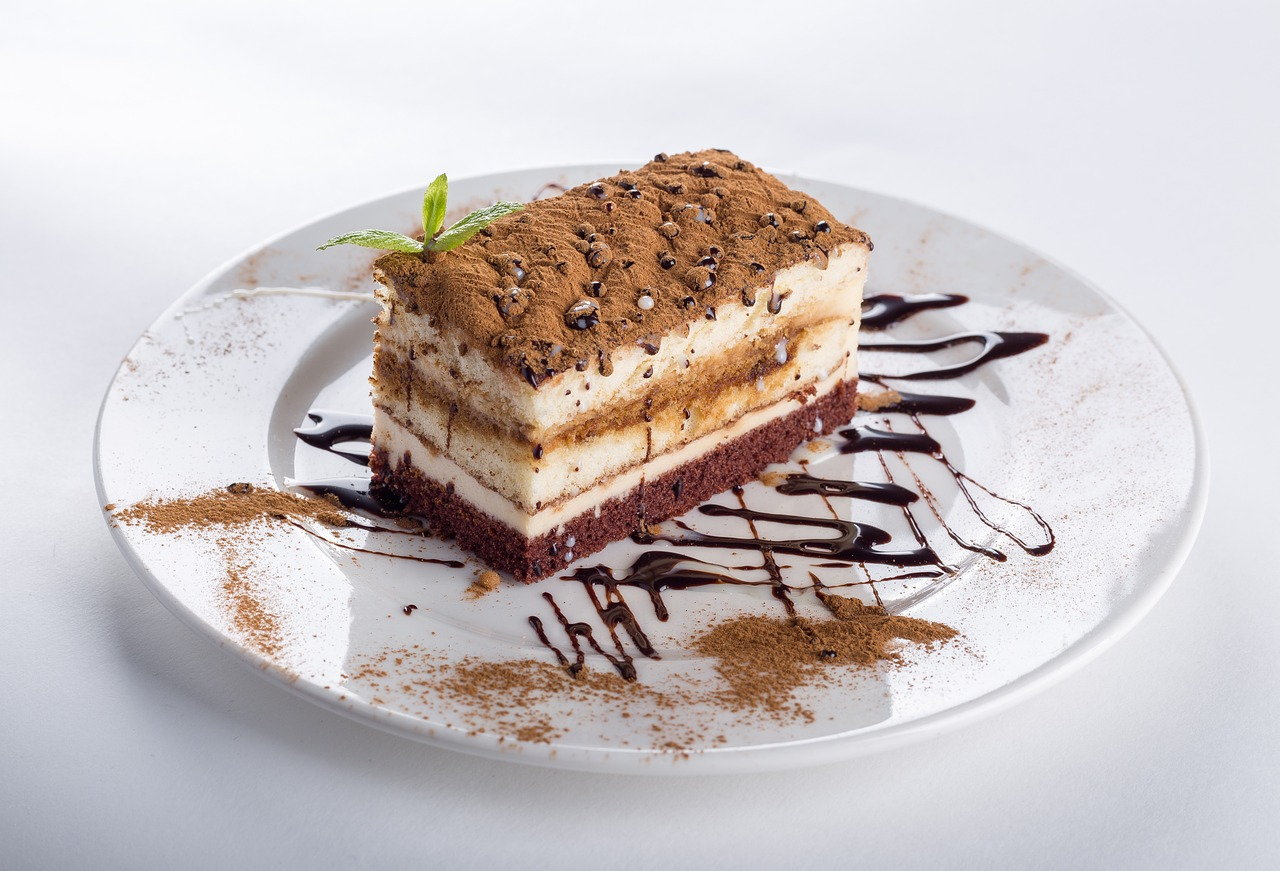

In [4]:
import PIL
from IPython.display import Image

!wget -nv https://storage.googleapis.com/generativeai-downloads/images/cake.jpg
Image('cake.jpg', width=500)

The Python SDK can take a list as the prompt input. This list represents a sequence of prompt parts, and while each part needs to be a single mode (such as text or image), you can combine them together to form a multi-modal prompt.

In [5]:
model = genai.GenerativeModel('gemini-1.5-flash-latest')

prompt = [
  "What is this? Please describe it in detail.",
  PIL.Image.open("cake.jpg"),
]

response = model.generate_content(prompt, request_options=retry_policy)
print(response.text)

This is a slice of tiramisu on a white plate. It is layered with ladyfingers, mascarpone cheese, and cocoa powder. The tiramisu is decorated with a sprig of mint and drizzled with chocolate sauce. There is also cocoa powder sprinkled around the plate.  Tiramisu is a classic Italian dessert and a popular choice for special occasions. It is known for its rich and creamy texture, and its sweet and slightly bitter taste.


Image understanding in the Gemini models can be quite powerful. Check out [this guide on object detection](https://github.com/google-gemini/cookbook/blob/main/examples/Object_detection.ipynb), where the Gemini API identifies and highlights objects in an image based on a prompt.

More input modes are supported, but first take a look at how to handle large files.

## Use and upload files

The Gemini models have very large context windows, up to 2 million input tokens are supported for the 1.5 Pro model. This translates to up to 2 hours of video or up to 19 hours of audio.

As files of this length are typically too large to send in HTTP requests, the Gemini API provides a File API to that you can use to send large files in requests. It also means you can reuse the same files across different requests without having to re-upload the same content each time, improving your request latency.

Note that some file limits exist, including how long they are kept. See [the note in the docs](https://ai.google.dev/gemini-api/docs/vision?hl=en&lang=python#upload-image) for more info.

### Audio

The Gemini API supports audio as an input medium. If you are the kind of person that takes audio notes with the Recorder or Voice Memo apps, this can be an efficient way to interact with your recordings ([check out this example](https://github.com/google-gemini/cookbook/blob/main/examples/Voice_memos.ipynb)), but you are not limited to personal notes.

This MP3 audio recording is a State of the Union addess from US president Kennedy. Running the following code should give you a playable audio controller so you can listen to it.

In [14]:
from pydub import AudioSegment
from IPython.display import Audio


!wget -nv https://storage.googleapis.com/generativeai-downloads/data/State_of_the_Union_Address_30_January_1961.mp3 -O speech.mp3

# This audio file is over 40mb, so trim the file before sending it to your browser.
full_speech = AudioSegment.from_mp3("speech.mp3")

# Preview the first 30 seconds.
first_30s_speech = full_speech[:30000]
first_30s_speech

# If you want to download and listen to the whole file, uncomment this.
# Audio("speech.mp3")

Now upload the full file so it can be used in a prompt.

In [15]:
uploaded_speech = genai.upload_file(path='speech.mp3')

In [16]:
prompt = "Who made the following speech? What were they positive about?"

model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content([prompt, uploaded_speech], request_options=retry_policy)
print(response.text)

This is the State of the Union address given by President **John F. Kennedy** on January 30, 1961. He was positive about the **American people's ability to face challenges** and their **willingness to overcome obstacles** in order to achieve progress. 



### Video



Now try out video understanding. In this example you will upload the ["Big Buck Bunny"](https://peach.blender.org/) short film and use the Gemini API to ask questions.

> "Big Buck Bunny" is (c) copyright 2008, Blender Foundation / www.bigbuckbunny.org and [licensed](https://peach.blender.org/about/) under the [Creative Commons Attribution 3.0](http://creativecommons.org/licenses/by/3.0/) License.

Start by downloading the video to this notebook and then uploading to the File API.

In [21]:
!wget https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4

print("Uploading to the File API...")
video_file = genai.upload_file(path="BigBuckBunny_320x180.mp4")
print("Upload complete")

--2024-11-15 04:58:56--  https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4
Resolving download.blender.org (download.blender.org)... 104.22.65.163, 104.22.64.163, 172.67.14.163, ...
Connecting to download.blender.org (download.blender.org)|104.22.65.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64657027 (62M) [video/mp4]
Saving to: 'BigBuckBunny_320x180.mp4.1'

BigBuckBunny_320x18 100%[===================>]  61.66M  19.6MB/s    in 3.3s    

2024-11-15 04:58:59 (18.6 MB/s) - 'BigBuckBunny_320x180.mp4.1' saved [64657027/64657027]

Uploading to the File API...
Upload complete


Larger files can take some time to process when they upload. Ensure that the file is ready to use.

In [22]:
import time

while video_file.state.name == "PROCESSING":
    print('Waiting for video to be processed.')
    time.sleep(10)
    video_file = genai.get_file(video_file.name)

if video_file.state.name == "FAILED":
  raise ValueError(video_file.state.name)

print(f'Video processing complete: ' + video_file.uri)

Waiting for video to be processed.
Video processing complete: https://generativelanguage.googleapis.com/v1beta/files/r1f1k30i7xdm


Now that it is ready, use it in a prompt. Note that using large files in requests typically takes more time than a small text request, so increase the timeout and be aware that you may have to wait for this response.

In [26]:
prompt = "What characters are in this movie?"

model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content([prompt, video_file],
                                  request_options=retry_policy | {"timeout": 600})
print(response.text)

The characters in this movie are:
* Big Buck Bunny
* A bird
* A chinchilla
* 2 squirrels 



## Streaming

So far, you have been making transactional requests with the Gemini API - send the request, receive a full response. The API also supports response streaming.

Pass `stream=True` to `generate_content` to trigger streaming mode. Note that it may render quickly - uncomment the final `print` to see each streamed chunk on its own.

In [23]:
prompt = """Write an essay defending why dogs are the best animals.
Treat the essay as serious and include proper essay structure."""

model = genai.GenerativeModel('gemini-1.5-flash-latest')

response = model.generate_content(prompt, stream=True, request_options=retry_policy)
for chunk in response:
    print(chunk.text, end='')
    # Uncomment this to see the individual tokens in separate sections.
    # print("\n----")

## Context caching

Context caching is a technique that allows you to cache part of a request, such that it does not need to be re-processed by the model each time you use it. This is useful, for example, for asking new questions of the same documents.

Note that context caching typically charges per million tokens per hour of caching. If you are using a paid API key, be sure to set your cache expiry or delete the cached tokens after use. See the [billing page](https://ai.google.dev/pricing) for more info. The Flash 1.5 model also supports caching on the free tier.

To ensure that the cache remains valid, caches are created by specifying versioned model names, so `gemini-1.5-flash-001`, where `-001` signifies the model version.

In [13]:
from google.generativeai import caching

# Download the transcript
!wget -O apollo11.txt https://storage.googleapis.com/generativeai-downloads/data/a11.txt

# Upload to the File API
transcript_file = genai.upload_file('apollo11.txt')

# Create a cache
apollo_cache = caching.CachedContent.create(
    model='gemini-1.5-flash-001',
    system_instruction="You are a space history buff that enjoys discussing and explaining historical space events.",
    contents=[transcript_file],
)

apollo_cache

CachedContent(
    name='cachedContents/glnql3wqgcpr',
    model='models/gemini-1.5-flash-001',
    display_name='',
    usage_metadata={
        'total_token_count': 323390,
    },
    create_time=2024-11-15 07:26:42.495679+00:00,
    update_time=2024-11-15 07:26:42.495679+00:00,
    expire_time=2024-11-15 08:26:42.134920+00:00
)

Now you can create a new model that uses this cache.

In [21]:
from IPython.display import Markdown

apollo_model = genai.GenerativeModel.from_cached_content(cached_content=apollo_cache)

response = apollo_model.generate_content("Find a nice moment from this transcript")
Markdown(response.text)

One particularly nice moment in the transcript occurs on **Tape 4/3, Page 27,** when CDR Neil Armstrong shares his view of the Earth from space: 

> "Well, we didn't have much time, Houston, to talk to you about our views out the window when we were preparing for LM ejection; but up to that time, we had the entire northern part of the lighted hemisphere visible including North America, North Atlantic, and Europe and Northern Africa. We could see that the weather was good all - just about everywhere."

This excerpt highlights the wonder and awe Armstrong experienced while gazing upon the Earth. It conveys a sense of peace and wonder, a moment of pure human appreciation for the vastness of the universe and the beauty of our home planet. It's a reminder of the profound impact space exploration has on our perspective and understanding of the world.


The response object includes information about the number of tokens that were cached and otherwise used in the prompt.

In [20]:
response.usage_metadata

prompt_token_count: 323398
candidates_token_count: 118
total_token_count: 323516
cached_content_token_count: 323390

And you can calculate how many non-cached tokens were used as input.

In [16]:
response.usage_metadata.total_token_count - response.usage_metadata.cached_content_token_count

194

### Delete the cache

To ensure you are not charged for any cached tokens you are not using, delete the cache. If you are on the free tier, you won't be charged, but it's good practice to clean up when you're done.

In [22]:
print(apollo_cache.name)
apollo_cache.delete()

cachedContents/glnql3wqgcpr


## Further reading

Take a look through the [Gemini API cookbook](https://github.com/google-gemini/cookbook) for more feature-based quickstarts and complex examples.

If you enabled billing on your API key and are finished with the key, you can [turn it off](https://ai.google.dev/gemini-api/docs/billing) unless you plan on using it again.

And thank you for coming with us on this 5-day learning journey!

\- [Mark McD](https://twitter.com/m4rkmc)